# Lab 4: Geostatistics

Name:

Date:

All the tasks in this lab are:
1) 1. Using the example code in Module 6 on Canvas, upward continue the data to account for changes in aircraft elevation - 1 pt
2) Crop your modeled Bouguer disturbance flightlines to exclude values within your inversion domain - 1 pt
3) Perform a normal score transformation on the remaining Bouguer values - 1 pt
4) Compute the experimental variogram for the remaining Bouguer values - 2 pt
5) Fit variogram models to the experimental variogram and select the best model - 2 pt
6) Apply sequential Gaussian simulation using the variogram model. Generate three realizations - 2 pt
7) Apply a reverse normal score transformation to the realizations. Then plot the results - 1 pt

Total = 10 pts

The overall objective of this lab is to geostatistically simulate the Bouguer disturbance within your study area. This is a crucial step in accounting for uncertainty in the Bouguer disturbance, which is a source of uncertainty in the gravity inversion. 

In [21]:
# for data manipulation and plotting
import verde as vd
import xarray as xr
import xrft
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import harmonica as hm

# geostatistics
import gstatsim as gs 
import skgstat as skg

import cmocean

from pathlib import Path
import warnings

from tqdm.auto import tqdm

# custom bathymetry and topo colormap
from utilities import get_topo_cm
topo_cm = get_topo_cm()


from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import random
import itertools
from utilities import xy_into_grid
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

## 1. Using the example code in Module 6 on Canvas, upward continue the data to account for changes in aircraft elevation

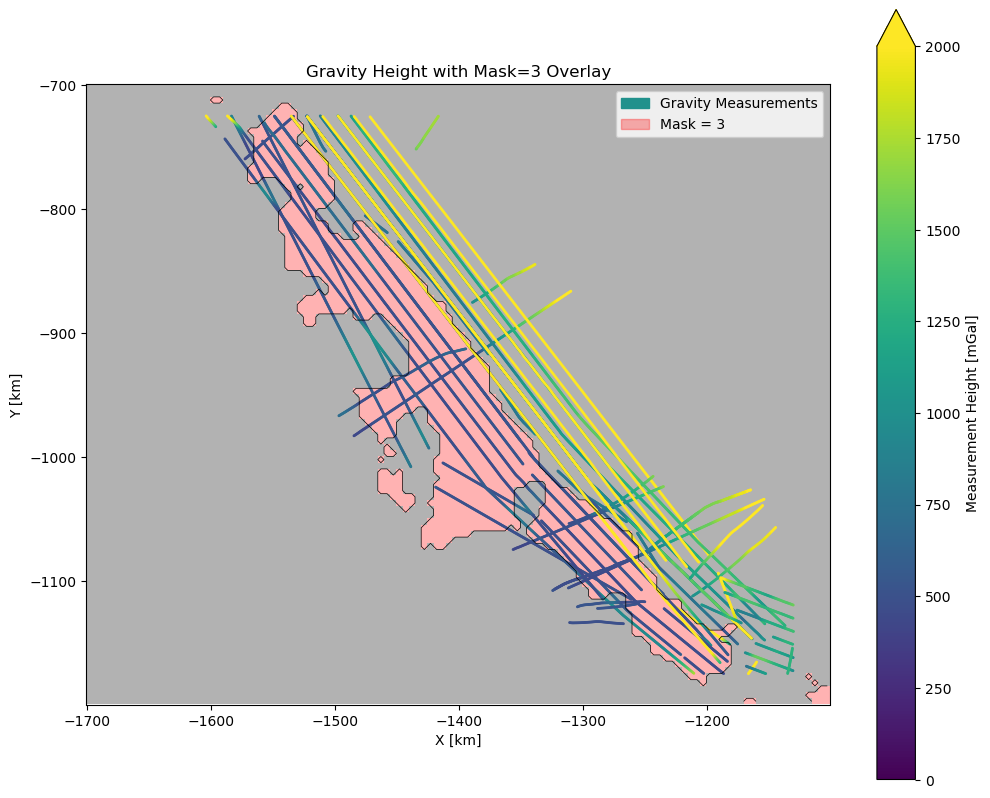

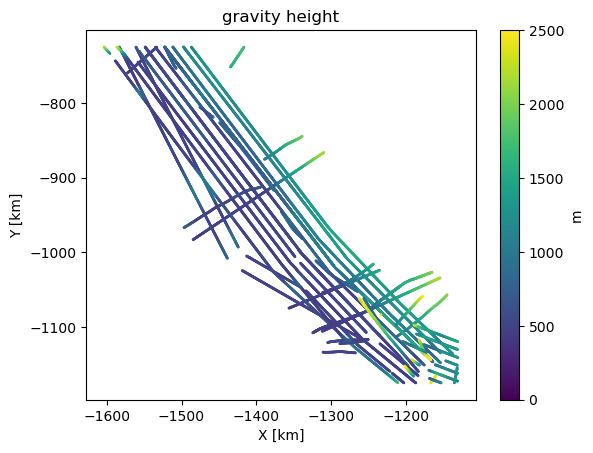

In [22]:
ds = xr.open_dataset('/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_bedmachine_dataset_polar_stereo.nc')
mask = ds['mask'].values  # 2D array representing mask regions

mask_x = ds['x'].values / 1000 
mask_y = ds['y'].values / 1000 

mask_X, mask_Y = np.meshgrid(mask_x, mask_y)

grav = pd.read_csv(Path('/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_gravity_dataset.csv'))
grav = grav.loc[::10, :] 

plt.figure(figsize=(12, 10))

cmap_overlay = ListedColormap(['none', 'red'])

plt.pcolormesh(
    mask_X,
    mask_Y,
    mask == 3,        
    cmap=cmap_overlay,
    alpha=0.3,         
    shading='auto'     
)
plt.contour(
    mask_X,
    mask_Y,
    mask == 3,
    levels=[0.5],          
    colors='black',       
    linewidths=0.5         
)

scatter = plt.scatter(
    grav.polar_stereo_x / 1000,    
    grav.polar_stereo_y / 1000,   
    c=grav.measurement_height,     
    s=1,                            
    vmin=0,                         
    vmax=2000,                      
    cmap='viridis',                 
    label='Gravity Measurements'    
)

cbar = plt.colorbar(scatter, label='Measurement Height [mGal]', extend='max')

plt.axis('scaled')
plt.title('Gravity Height with Mask=3 Overlay')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

cmap = plt.get_cmap('viridis')
color1 = cmap(0.5)
legend_elements = [
    Patch(facecolor=color1, edgecolor=color1, label='Gravity Measurements'),
    Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Mask = 3')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

height = 2500
grav = grav[grav.measurement_height < height]

plt.scatter(grav.polar_stereo_x/1000, grav.polar_stereo_y/1000, c=grav.measurement_height, s=1, vmin=0, vmax=2500)
plt.axis('scaled')
plt.title('gravity height')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(label='m')
plt.show()



Number of combinations: 12


  0%|          | 0/12 [00:00<?, ?it/s]

Best score: 0.9988001748709479
Best parameters: {'damping': 0.1, 'depth': 3000.0}


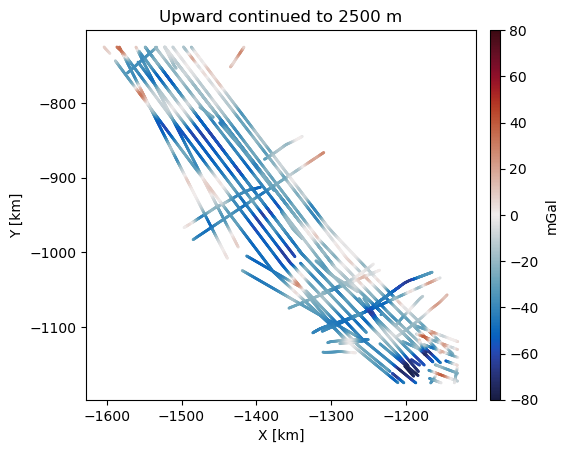

Upward continued gravity data saved to /Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/upward_continued_gravity.csv


In [26]:
dampings = [0.01, 0.1, 1, 10]
depths = [2e3, 3e3, 4e3]

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

# Gradient Boosted Equivalent sources
equivalent_sources = hm.EquivalentSourcesGB(window_size=20e3)

# Use downsampled data since so dense
coordinates = (grav.polar_stereo_x, grav.polar_stereo_y, grav.measurement_height)

scores = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for params in tqdm(parameter_sets):
        equivalent_sources.set_params(**params)
        score = np.mean(
            vd.cross_val_score(
                equivalent_sources,
                coordinates,
                grav.faa140,
            )
        )
        scores.append(score)
scores

best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

pred_coords = (grav.polar_stereo_x, grav.polar_stereo_y, np.full(grav.polar_stereo_x.size, height))

# use parameters from cross validation
equivalent_sources = hm.EquivalentSourcesGB(**parameter_sets[best], window_size=20e3)

equivalent_sources.fit(coordinates, grav.faa140.values)
leveled = equivalent_sources.predict(pred_coords)

balance = cmocean.cm.balance

plt.scatter(grav.polar_stereo_x/1000, grav.polar_stereo_y/1000, c=leveled, s=1, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.title(f'Upward continued to {height} m')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.show()

# Add 'leveled' gravity data to the DataFrame
grav['leveled_gravity'] = leveled  # <-- Added Line

# Save the updated DataFrame to a new CSV file
save_csv_path = '/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/upward_continued_gravity.csv'  # <-- Specify your desired path
grav.to_csv(save_csv_path, index=False)  # <-- Added Line

print(f"Upward continued gravity data saved to {save_csv_path}")  # <-- Added Line

Gridded upward continued gravity data saved to /Users/holden/Desktop/Ice Shits/upward_continued_gravity.nc


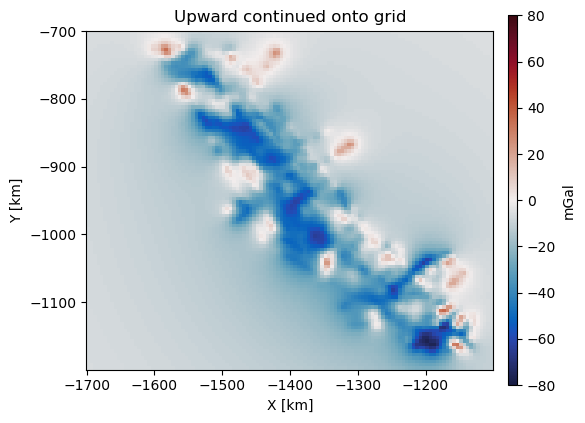

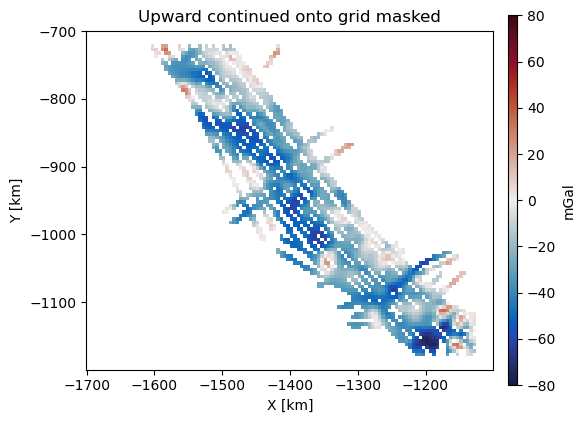

In [25]:
xx, yy = np.meshgrid(ds.x, ds.y)
pred_coords = (xx, yy, np.full(xx.shape, height))

leveled_grid = equivalent_sources.predict(pred_coords)

gravity_da = xr.DataArray(
    leveled_grid,
    coords={
        'y': ds.y.values,
        'x': ds.x.values,
    },
    dims=['y', 'x'],
    name='upward_continued_gravity',
    attrs={
        'units': 'mGal',
        'description': 'Gravity data after upward continuation onto a regular grid'
    }
)

# Define the path where you want to save the NetCDF file
save_path = '/Users/holden/Desktop/Ice Shits/upward_continued_gravity.nc'

# Save the DataArray to a NetCDF file
gravity_da.to_netcdf(save_path)

print(f"Gridded upward continued gravity data saved to {save_path}")

plt.pcolormesh(ds.x/1000, ds.y/1000, leveled_grid, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.title('Upward continued onto grid')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

dist_msk = vd.distance_mask(coordinates[:2], 4000, pred_coords[:2])
leveled_mask = np.where(dist_msk, leveled_grid, np.nan)

plt.pcolormesh(ds.x/1000, ds.y/1000, leveled_mask, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.title('Upward continued onto grid masked')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

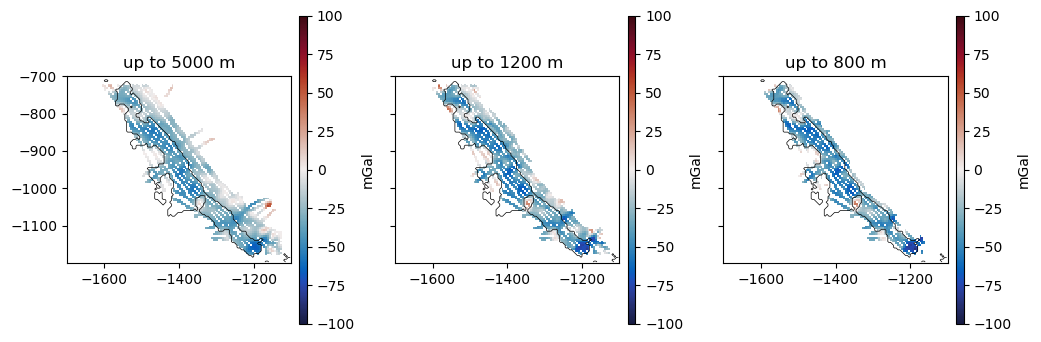

In [5]:
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.measurement_height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.polar_stereo_x.values, grav_tmp.polar_stereo_y.values, grav_tmp.measurement_height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa140.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

grav2 = pd.read_csv(Path('/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_gravity_dataset.csv'))
grav2 = grav2.loc[::10,:]

heights = [5000, 1200, 800]

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for ax, h in zip(axs, heights):
    
    leveled_i = upward_continue(grav2, h, ds, 4000)
    
    im = ax.pcolormesh(xx/1000, yy/1000, leveled_i, vmin=-100, vmax=100, cmap=balance)
    ax.contour(ds.x/1000, ds.y/1000, ds.mask==3, levels=[0.5], colors='k', linewidths=0.5)
    ax.axis('scaled')
    ax.set_title(f'up to {h} m')
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')

plt.show()

## 2. Crop your upward continued data to exclude values within your inversion domain - 1 pt

Load in your Bouguer disturbance from Lab 3, or re-generate it here

Crop your Bouguer disturbance flight lines so that any values within your ice shelf inversion domain are excluded. We exclude these values because the topography beneath the ice shelf is quite uncertain, which means that we are not confident in our Bouguer disturbance values. As such, we omit them.

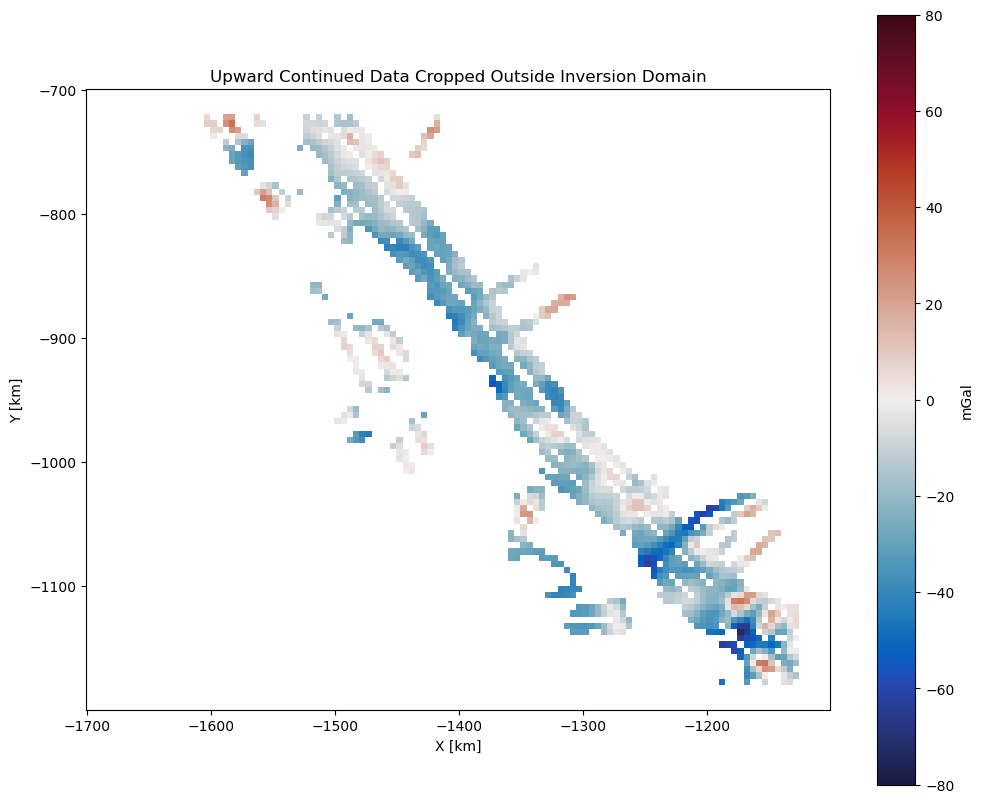

In [6]:
inversion_domain = (mask == 3)

crop_mask = ~inversion_domain  

cropped_leveled = np.where(crop_mask, leveled_mask, np.nan)

plt.figure(figsize=(12, 10))
plt.pcolormesh(ds.x / 1000, ds.y / 1000, cropped_leveled, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.title('Upward Continued Data Cropped Outside Inversion Domain')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(label='mGal')
plt.show()


## 3) Perform a normal score transformation on the remaining Bouguer values - 1 pt

Geostatistical methods work best on data that resembles a standard Gaussian distribution. Using the first part of the tutorial here (https://gatorglaciology.github.io/gstatsimbook/1_Experimental_Variogram.html), perform a normal score transformation on the remainder of your Bouguer data. Plot the before and after histograms to check that the new data is Gaussian.

In [7]:
res = 5000  # Grid resolution in meters
ds.attrs['res'] = res

In [9]:
# Step 1: PGEN
from prisms import PrismGen

density_dict = {
    'rock': 2670,
    'ice': 890,
    'water': 1030
}

pgen = PrismGen(density_dict)
prisms, densities = pgen.make_prisms(ds, ds.bed.values, msk='all')
print(f"Number of prisms generated: {prisms.shape[0]}")

# Step 2: Remove Spurious Prisms
def remove_spurious_prisms(prisms, densities):
    valid = prisms[:, 4] < prisms[:, 5]
    return prisms[valid], densities[valid]

prisms_valid, densities_valid = remove_spurious_prisms(prisms, densities)
print(f"Number of valid prisms after removing spurious ones: {prisms_valid.shape[0]}")

# Step 3: Prepare Observation Points
easting = ds['x'].values
northing = ds['y'].values
shape = (len(northing), len(easting))
xx, yy = np.meshgrid(easting, northing)
x_obs = xx.ravel()
y_obs = yy.ravel()
height = 5000  # Adjust as needed
z_obs = np.full_like(x_obs, height)
coordinates = (x_obs, y_obs, z_obs)
print(f"Number of observation points: {len(x_obs)}")

# Step 4: Forward Model Gravity Effects
g_total = hm.prism_gravity(coordinates, prisms_valid, densities_valid, field='g_z')
g_total_grid = g_total.reshape(shape)

Number of prisms generated: 25345
Number of valid prisms after removing spurious ones: 20539
Number of observation points: 12000


In [10]:
# Check shapes of the grids
print("Shape of upward continued data:", cropped_leveled.shape)
print("Shape of terrain effect grid:", g_total_grid.shape)

# Ensure that shapes match
assert cropped_leveled.shape == g_total_grid.shape, "Grids are not the same shape."

# Ensure that the x and y coordinates match
easting = ds['x'].values  # X coordinates
northing = ds['y'].values  # Y coordinates
xx, yy = np.meshgrid(easting, northing)

# Calculate the Bouguer disturbance
bouguer_disturbance = cropped_leveled - g_total_grid

Shape of upward continued data: (100, 120)
Shape of terrain effect grid: (100, 120)


Plot the transformed Bouguer data.

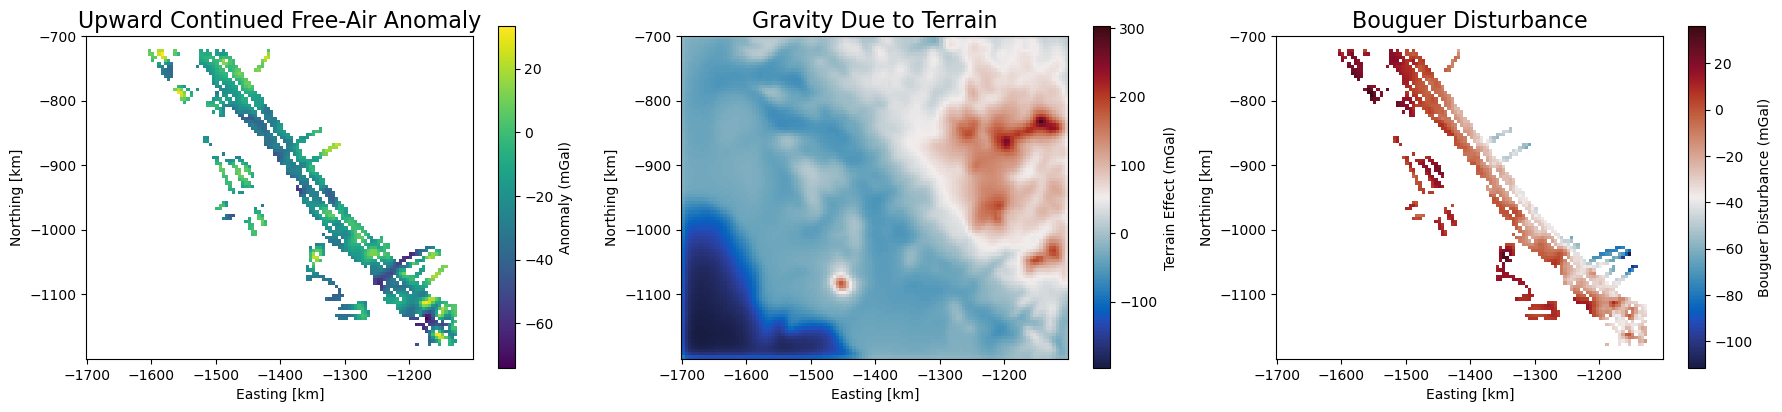

In [11]:
# Reshape coordinates to grid shape
x_grid = xx / 1000  # Convert to kilometers
y_grid = yy / 1000  # Convert to kilometers

# Prepare data for plotting
upward_continued_data = cropped_leveled
terrain_effect_data = g_total_grid

import matplotlib.pyplot as plt
import cmocean

balance = cmocean.cm.balance
viridis = plt.cm.viridis
cb_shrink = 0.6

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Upward Continued Free-Air Anomaly
im1 = axs[0].pcolormesh(
    x_grid, y_grid, upward_continued_data, cmap=viridis, shading='auto'
)
axs[0].set_title('Upward Continued Free-Air Anomaly', fontsize=16)
axs[0].set_xlabel('Easting [km]')
axs[0].set_ylabel('Northing [km]')
axs[0].axis('scaled')
cb1 = plt.colorbar(im1, ax=axs[0], orientation='vertical', label='Anomaly (mGal)', shrink=cb_shrink)

# Terrain Effect
im2 = axs[1].pcolormesh(
    x_grid, y_grid, terrain_effect_data, cmap=balance, shading='auto'
)
axs[1].set_title('Gravity Due to Terrain', fontsize=16)
axs[1].set_xlabel('Easting [km]')
axs[1].set_ylabel('Northing [km]')
axs[1].axis('scaled')
cb2 = plt.colorbar(im2, ax=axs[1], orientation='vertical', label='Terrain Effect (mGal)', shrink=cb_shrink)

# Bouguer Disturbance
im3 = axs[2].pcolormesh(
    x_grid, y_grid, bouguer_disturbance, cmap=balance, shading='auto'
)
axs[2].set_title('Bouguer Disturbance', fontsize=16)
axs[2].set_xlabel('Easting [km]')
axs[2].set_ylabel('Northing [km]')
axs[2].axis('scaled')
cb3 = plt.colorbar(im3, ax=axs[2], orientation='vertical', label='Bouguer Disturbance (mGal)', shrink=cb_shrink)

plt.tight_layout()
plt.show()

# Extract gravity data coordinates
grav_x = grav['polar_stereo_x'].values
grav_y = grav['polar_stereo_y'].values

# Find the minimum and maximum x and y coordinates
x_min = grav_x.min()
x_max = grav_x.max()
y_min = grav_y.min()
y_max = grav_y.max()

print(f"Gravity data X range: {x_min} to {x_max}")
print(f"Gravity data Y range: {y_min} to {y_max}")

# Grid coordinates from your dataset
easting = ds['x'].values
northing = ds['y'].values

# Create masks for grid points within the gravity data extent
within_x = (easting >= x_min) & (easting <= x_max)
within_y = (northing >= y_min) & (northing <= y_max)

# Overwrite the grid coordinates with the cropped versions
easting = easting[within_x]
northing = northing[within_y]

# Recreate the meshgrid with the updated coordinates
xx, yy = np.meshgrid(easting, northing)

# Find the indices corresponding to the cropped coordinates
x_indices = np.where(within_x)[0]
y_indices = np.where(within_y)[0]

# Overwrite the data arrays with the cropped versions
cropped_leveled = cropped_leveled[np.ix_(y_indices, x_indices)]
g_total_grid = g_total_grid[np.ix_(y_indices, x_indices)]
bouguer_disturbance = bouguer_disturbance[np.ix_(y_indices, x_indices)]

# Update the shape variable
shape = bouguer_disturbance.shape
print(f"Updated grid shape: {shape}")

# Proceed with your analysis using the same variable names
# Step 4: Perform a Normal Score Transformation
# ... (Your existing code for normal score transformation)

# Ensure you use the updated variables (which have the same names)


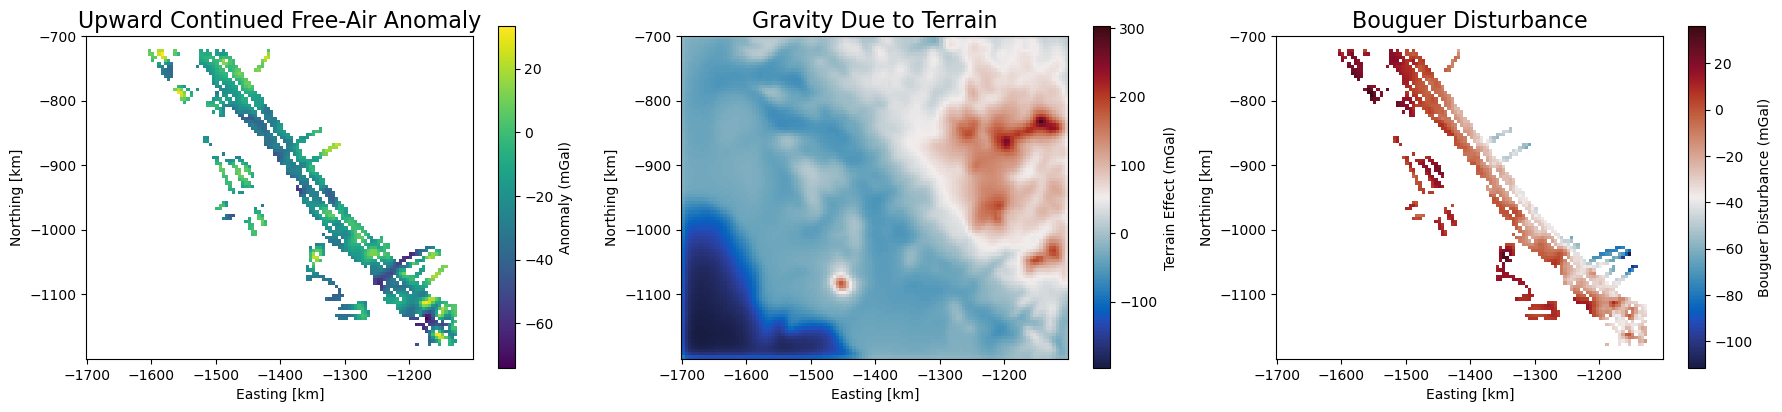

In [12]:
# Reshape coordinates to grid shape
x_grid = xx / 1000  # Convert to kilometers
y_grid = yy / 1000  # Convert to kilometers

# Prepare data for plotting
upward_continued_data = cropped_leveled
terrain_effect_data = g_total_grid

import matplotlib.pyplot as plt
import cmocean

balance = cmocean.cm.balance
viridis = plt.cm.viridis
cb_shrink = 0.6

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Upward Continued Free-Air Anomaly
im1 = axs[0].pcolormesh(
    x_grid, y_grid, upward_continued_data, cmap=viridis, shading='auto'
)
axs[0].set_title('Upward Continued Free-Air Anomaly', fontsize=16)
axs[0].set_xlabel('Easting [km]')
axs[0].set_ylabel('Northing [km]')
axs[0].axis('scaled')
cb1 = plt.colorbar(im1, ax=axs[0], orientation='vertical', label='Anomaly (mGal)', shrink=cb_shrink)

# Terrain Effect
im2 = axs[1].pcolormesh(
    x_grid, y_grid, terrain_effect_data, cmap=balance, shading='auto'
)
axs[1].set_title('Gravity Due to Terrain', fontsize=16)
axs[1].set_xlabel('Easting [km]')
axs[1].set_ylabel('Northing [km]')
axs[1].axis('scaled')
cb2 = plt.colorbar(im2, ax=axs[1], orientation='vertical', label='Terrain Effect (mGal)', shrink=cb_shrink)

# Bouguer Disturbance
im3 = axs[2].pcolormesh(
    x_grid, y_grid, bouguer_disturbance, cmap=balance, shading='auto'
)
axs[2].set_title('Bouguer Disturbance', fontsize=16)
axs[2].set_xlabel('Easting [km]')
axs[2].set_ylabel('Northing [km]')
axs[2].axis('scaled')
cb3 = plt.colorbar(im3, ax=axs[2], orientation='vertical', label='Bouguer Disturbance (mGal)', shrink=cb_shrink)

plt.tight_layout()
plt.show()

## 4) Compute the experimental variogram for the remaining Bouguer values - 2 pt

You can do this by following this tutorial: https://gatorglaciology.github.io/gstatsimbook/1_Experimental_Variogram.html

You only need to do the isotropic variogram. Don't worry about different directions. Plot the experimental variogram. 

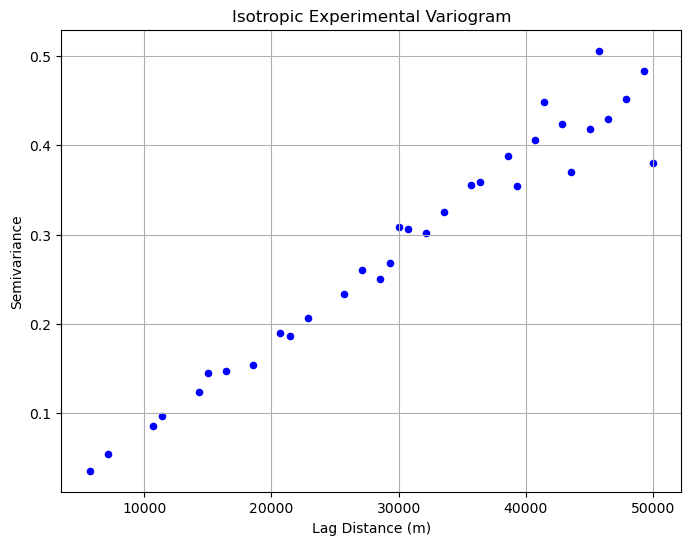

In [13]:
# Flatten the coordinate grids and the Bouguer disturbance data
x_coords = xx.ravel()
y_coords = yy.ravel()
bouguer_flat = bouguer_disturbance.ravel()

# Identify valid (non-NaN) indices
valid_indices = ~np.isnan(bouguer_flat)

# Extract valid coordinates and Bouguer disturbance values
valid_x_coords = x_coords[valid_indices]
valid_y_coords = y_coords[valid_indices]
valid_bouguer = bouguer_flat[valid_indices]

# Normalize the Bouguer disturbance values using normal score transformation
from sklearn.preprocessing import QuantileTransformer

# Reshape data for the transformer
data = valid_bouguer.reshape(-1, 1)

# Initialize and fit the transformer
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)

# Transform the data
normalized_bouguer = nst_trans.transform(data).flatten()

# Combine valid coordinates into an array
coords = np.column_stack((valid_x_coords, valid_y_coords))
values = normalized_bouguer  # Normalized Bouguer disturbance values

# Define variogram parameters
maxlag = 50000  # Maximum lag distance (50 km)
n_lags = 70     # Number of lag bins

# Compute the isotropic experimental variogram
variogram = skg.Variogram(
    coords,
    values,
    bin_func='even',
    n_lags=n_lags,
    maxlag=maxlag,
    normalize=False
)

# Extract variogram values
lag_distances = variogram.bins
semivariance = variogram.experimental

# Plot the experimental variogram
plt.figure(figsize=(8, 6))
plt.scatter(lag_distances, semivariance, c='blue', s=20)
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag Distance (m)')
plt.ylabel('Semivariance')
plt.grid(True)
plt.show()

## 5) Fit variogram models to the experimental variogram and select the best model - 2 pt

Use this tutorial: https://gatorglaciology.github.io/gstatsimbook/2_Variogram_model.html

Fit and plot the Gaussian, exponential, and spherical variogram models. Print a statement about which one you think is the best fit. Note: when determining which one is the best fit, it's most important that the model fits well at short lags.

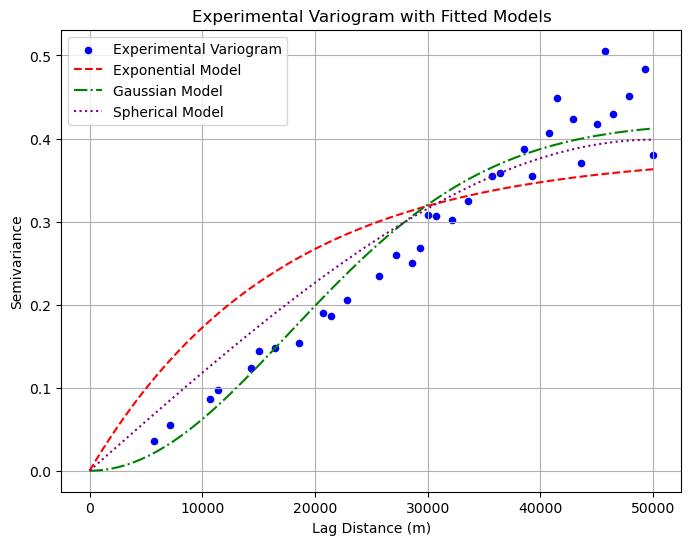

Available variogram models:
1. Exponential
2. Gaussian
3. Spherical


Enter the number corresponding to your chosen variogram model:  3



You have chosen the Spherical variogram model.

Parameters of the chosen model:
Sill: 0.3986409606955451
Range: 49999.99999999999
Nugget: 0


In [14]:
from skgstat import models

# Define lag distances for model curves
xi = np.linspace(0, maxlag, 100)

# Initialize dictionaries to store model parameters and semivariances
model_params = {}
model_semivariances = {}

# List of models to fit
model_list = ['exponential', 'gaussian', 'spherical']

# Fit models and compute semivariances
for model_name in model_list:
    # Create a copy of the variogram with the specified model
    var_model = skg.Variogram(
        coords,
        values,
        bin_func='even',
        n_lags=n_lags,
        maxlag=maxlag,
        normalize=False,
        model=model_name
    )
    
    # Extract model parameters: range, sill, nugget
    range_, sill, nugget = var_model.parameters
    model_params[model_name] = (sill, range_, nugget)
    
    # Compute model semivariances for plotting
    if model_name == 'exponential':
        y_model = models.exponential(xi, range_, sill, nugget)
    elif model_name == 'gaussian':
        y_model = models.gaussian(xi, range_, sill, nugget)
    elif model_name == 'spherical':
        y_model = models.spherical(xi, range_, sill, nugget)
    
    model_semivariances[model_name] = y_model

# Plot experimental variogram with fitted models
plt.figure(figsize=(8, 6))
plt.scatter(lag_distances, semivariance, c='blue', s=20, label='Experimental Variogram')

colors = {'exponential': 'red', 'gaussian': 'green', 'spherical': 'purple'}
linestyles = {'exponential': '--', 'gaussian': '-.', 'spherical': ':'}

for model_name in model_list:
    plt.plot(xi, model_semivariances[model_name], linestyle=linestyles[model_name], 
             color=colors[model_name], label=f'{model_name.capitalize()} Model')

plt.title('Experimental Variogram with Fitted Models')
plt.xlabel('Lag Distance (m)')
plt.ylabel('Semivariance')
plt.legend()
plt.grid(True)
plt.show()

# Prompt the user to choose the variogram model
print("Available variogram models:")
for idx, model_name in enumerate(model_list, start=1):
    print(f"{idx}. {model_name.capitalize()}")

# Input validation loop
while True:
    try:
        choice = int(input("Enter the number corresponding to your chosen variogram model: "))
        if 1 <= choice <= len(model_list):
            chosen_model = model_list[choice - 1]
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

print(f"\nYou have chosen the {chosen_model.capitalize()} variogram model.")

# Retrieve the parameters of the chosen model
best_sill, best_range, best_nugget = model_params[chosen_model]
print(f"\nParameters of the chosen model:")
print(f"Sill: {best_sill}")
print(f"Range: {best_range}")
print(f"Nugget: {best_nugget}")

## 6) Apply sequential Gaussian simulation using the variogram model. Generate three realizations - 2 pt

Use the tutorial here to generate three SGS realizations using your chosen variogram model parameters: https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html

In [16]:
sgs_data = pd.DataFrame({
    'X': valid_x_coords,
    'Y': valid_y_coords,
    'Value': normalized_bouguer
})

Pred_grid_xy = np.column_stack((x_coords, y_coords))

# Use the variogram model parameters
sill = best_sill
range_ = best_range
nugget = best_nugget
azimuth = 0  # Assuming isotropic variogram
major_range = range_
minor_range = range_
vtype = chosen_model  # Variogram typ

# Variogram parameters list for gstatsim
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]

# Kriging parameters
k = 64          # Number of neighboring data points
rad = 225000    # Search radius in meters (200 km)

# Function to perform SGS with a given random seed
def perform_sgs(sim_number, seed):
    print(f"Generating simulation {sim_number} with {vtype} variogram model and random seed {seed}...")
    try:
        # Set the random seed globally
        np.random.seed(seed)
        random.seed(seed)
        
        sim = gs.Interpolation.okrige_sgs(
            Pred_grid_xy,
            sgs_data,
            'X',
            'Y',
            'Value',
            k,
            vario,
            rad
        )
        print(f"Simulation {sim_number} completed with random seed {seed}.")
        return sim
    except Exception as e:
        print(f"Error during simulation {sim_number} with random seed {seed}: {e}")
        return None

# Perform SGS to generate three realizations
simulations = []
max_attempts = 1  # Maximum number of attempts per simulation

for i in range(1, 4):
    success = False
    attempts = 0
    while attempts < max_attempts:
        attempts += 1
        # Generate a random seed
        seed = random.randint(0, 100000)
        sim = perform_sgs(i, seed)
        if sim is not None:
            simulations.append(sim)
            success = True
            break  # Exit the loop if successful
        else:
            print(f"Attempt {attempts} for simulation {i} failed. Trying a new seed...")
    if not success:
        print(f"Failed to generate simulation {i} after {max_attempts} attempts.")
        break  # Exit if unable to generate the simulation

# Check if all simulations were generated
if len(simulations) < 3:
    raise RuntimeError("Failed to generate all three SGS realizations.")


Generating simulation 1 with spherical variogram model and random seed 69585...


100%|████████████████████████████████████| 12000/12000 [01:13<00:00, 163.75it/s]


Simulation 1 completed with random seed 69585.
Generating simulation 2 with spherical variogram model and random seed 67057...


100%|████████████████████████████████████| 12000/12000 [01:13<00:00, 163.65it/s]


Simulation 2 completed with random seed 67057.
Generating simulation 3 with spherical variogram model and random seed 94358...


100%|████████████████████████████████████| 12000/12000 [01:13<00:00, 163.85it/s]

Simulation 3 completed with random seed 94358.


## 7) Apply a reverse normal score transformation to the realizations. Then plot the results - 1 pt

Reverse the normal score transformation and plot the three realizations. You can refer to this tutorial for an example of how to reverse the normal score transformation: https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html

Processing simulation 1 for inverse transformation...


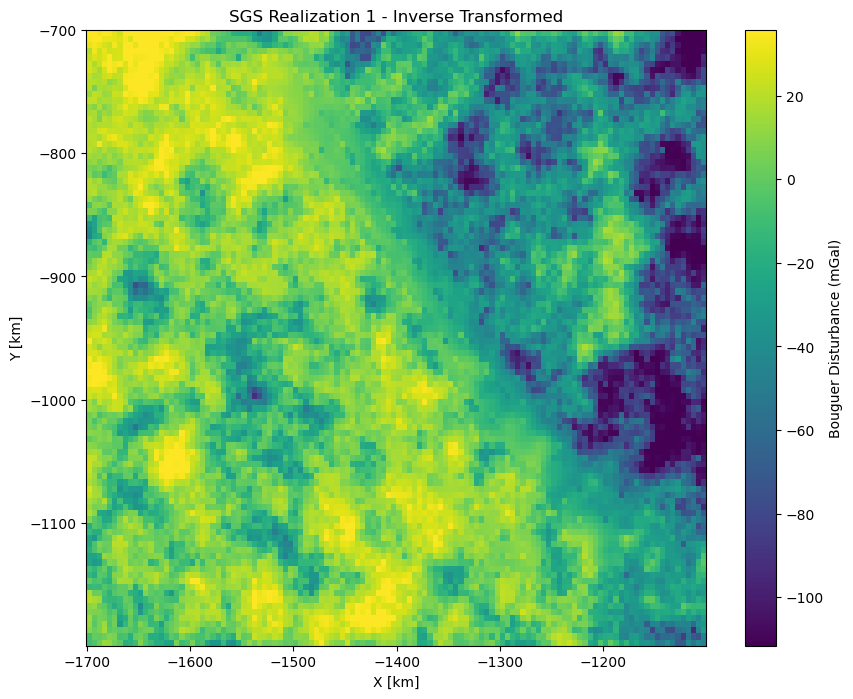

Processing simulation 2 for inverse transformation...


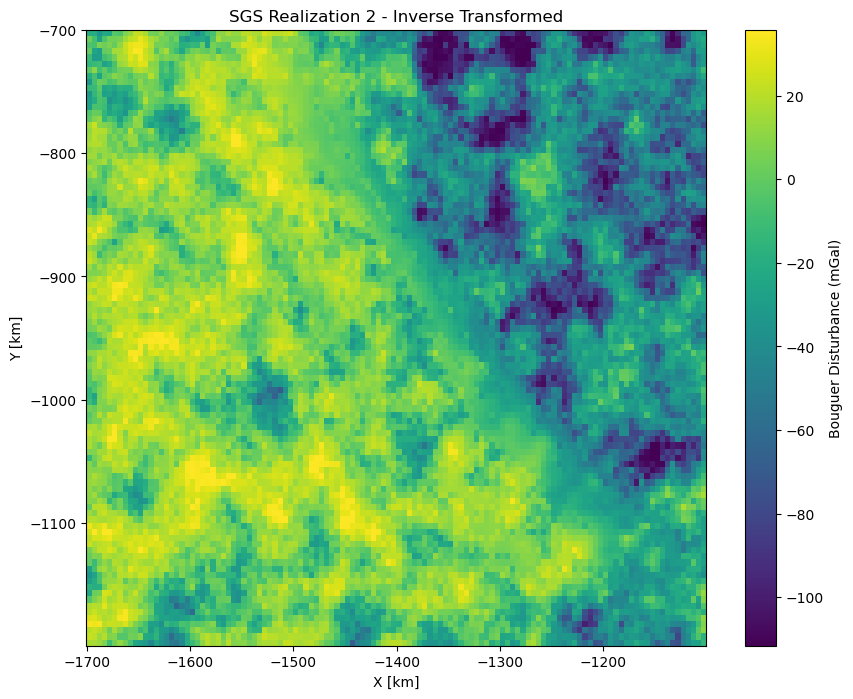

Processing simulation 3 for inverse transformation...


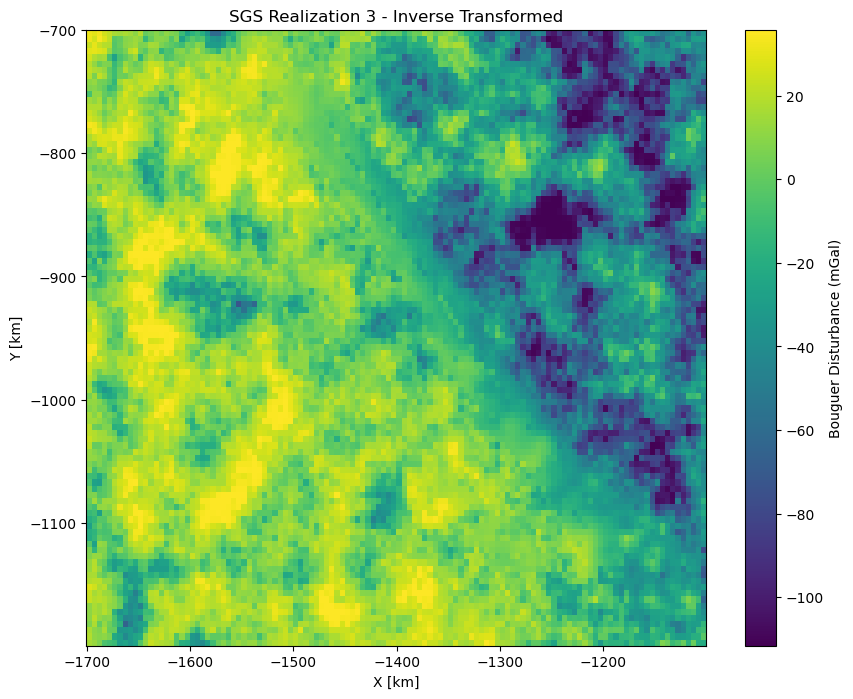

In [17]:
# Initialize a list to store transformed simulations
simulations_transformed = []

for i, sim in enumerate(simulations, start=1):
    print(f"Processing simulation {i} for inverse transformation...")
    try:
        # Reshape the simulation array for transformation
        sim_reshaped = sim.reshape(-1, 1)
        
        # Apply inverse normal score transformation
        sim_inverse = nst_trans.inverse_transform(sim_reshaped)
        
        # Reshape to grid shape
        sim_grid = sim_inverse.reshape(xx.shape)
        
        # Append to the list
        simulations_transformed.append(sim_grid)
        
        # Plot the simulation
        plt.figure(figsize=(10, 8))
        plt.pcolormesh(
            xx / 1000,
            yy / 1000,
            sim_grid,
            cmap='viridis',
            shading='auto'
        )
        plt.colorbar(label='Bouguer Disturbance (mGal)')
        plt.xlabel('X [km]')
        plt.ylabel('Y [km]')
        plt.title(f'SGS Realization {i} - Inverse Transformed')
        plt.show()
    except Exception as e:
        print(f"Error during inverse transformation of simulation {i}: {e}")

# Verify that all simulations have been transformed
if len(simulations_transformed) != 3:
    raise RuntimeError("Not all simulations were successfully inverse transformed.")

np.savez(
    'sgs_simulations.npz',
    sim1=simulations_transformed[0],
    sim2=simulations_transformed[1],
    sim3=simulations_transformed[2]
)